In [1]:
pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda update protobuf

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::keras==2.3.1=0
  - defaults/osx-64::tensorflow==2.0.0=mkl_py37hda344b4_0
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::keras==2.3.1=0
  - defaults/osx-64::tensorflow==2.0.0=mkl_py37hda344b4_0
done

## Package Plan ##

  environment location: /Users/charlottedurand/opt/anaconda3/envs/tf_2

  added / updated specs:
    - protobuf


The following NEW packages will be INSTALLED:

  tensorboard        pkgs/main/noarch::tensorboard-2.0.0-pyhb38c66f_1


Preparing transaction: done
Verifying transaction: don

In [4]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [8]:
!git clone https://github.com/CIA-Oceanix/DinAE_4DVarNN_torch.git

Cloning into 'DinAE_4DVarNN_torch'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 106 (delta 41), reused 42 (delta 9), pack-reused 0
Receiving objects: 100% (106/106), 4.25 MiB | 2.11 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import pytorch_lightning as pl
import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from pytorch_lightning import loggers as pl_loggers

from sklearn import decomposition
import scipy
from scipy.integrate import solve_ivp

from sklearn.feature_extraction import image

from utils import *

In [9]:
os.chdir('DinAE_4DVarNN_torch')
import torch_4DVarNN_dinAE as NN_4DVar
os.chdir('../')
!pwd

/Users/charlottedurand/Documents/GitHub/DataAssimilationProject


# L63 Data simulation

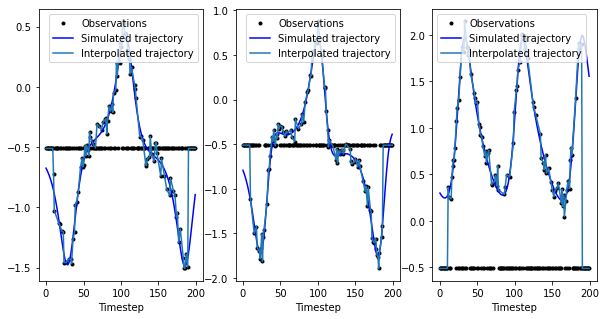

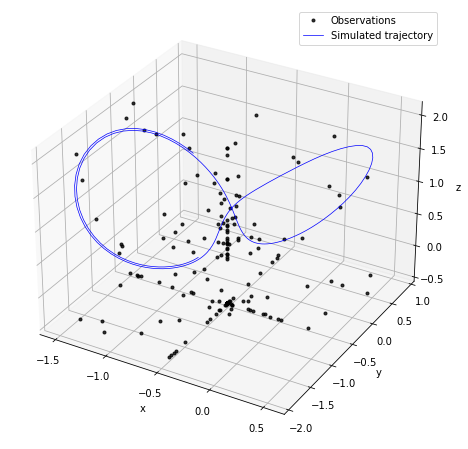

In [17]:
## data generation: L63 series
SD = Simulation_data()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(SD.dt_integration,SD.nb_loop_test*SD.dt_integration+0.000001,SD.dt_integration)
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,SD.parameters.sigma,SD.parameters.rho,SD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=SD.dt_integration,t_eval=np.arange(0,5+0.000001,SD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,SD.parameters.sigma,SD.parameters.rho,SD.parameters.beta),t_span=[SD.dt_integration,SD.nb_loop_test+0.000001],y0=y0,first_step=SD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()
  
xt = time_series()
xt.values = S
xt.time   = tt

#Data Extraction
X_train, X_val, X_test, X_train_obs, X_val_obs,X_test_obs, X_train_missing, X_val_missing,X_test_missing, mask_train,mask_val, mask_test, X_train_Init,X_val_Init ,X_test_Init,meanTr, stdTr =  L63PatchDataExtraction(xt=xt,RMD=0.5)

meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 
stdTr           = np.sqrt( np.mean( X_train_missing**2 ) / np.mean(mask_train) )

meanTe          = np.mean(X_test_missing[:]) / np.mean(mask_test) 
stdTe           = np.sqrt( np.mean( X_test_missing**2 ) / np.mean(mask_test) )

meanV          = np.mean(X_val_missing[:]) / np.mean(mask_val) 
stdV           = np.sqrt( np.mean( X_val_missing**2 ) / np.mean(mask_val) )

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTe) / stdTe
x_val  = (X_val - meanV) / stdV


x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTe) / stdTe
x_val_obs  = (X_val_obs - meanV) / stdV

x_train_Init = (X_train_Init - meanTr) / stdTr
x_test_Init  = (X_test_Init - meanTe) / stdTe
x_val_Init  = (X_val_Init - meanV) / stdV
#Data Visualisation
visualisation_data(x_train,x_train_obs,x_train_Init,180)

# 4DVarNet Architecture

In [18]:
shapeData  = x_train.shape[1:]
dW = 1
DimCNN = 10
DimAE  = 10
dW = 1
class Encoder(pl.LightningModule):
    def __init__(self):
        super(Encoder, self).__init__()
        
        
        self.pool1  = torch.nn.AvgPool1d(4)
        self.conv1  = NN_4DVar.ConstrainedConv1d(shapeData[0],2*shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
        self.conv2  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
        self.conv21 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.conv22 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.conv23 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.conv3  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
        self.conv2Tr = torch.nn.ConvTranspose1d(shapeData[0]*DimAE,shapeData[0],4,stride=4,bias=False)          
         
        self.convHR1  = NN_4DVar.ConstrainedConv1d(shapeData[0],2*shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
        self.convHR1  = NN_4DVar.ConstrainedConv1d(shapeData[0],2*shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
        self.convHR2  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
        self.convHR21 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.convHR22 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.convHR23 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.convHR3  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)

    def forward(self, xinp):
        x = self.pool1( xinp )
        x = self.conv1( x )
        x = self.conv2( F.relu(x) )
        x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
        x = self.conv3( x )
        x = self.conv2Tr( x )
          
        xHR = self.convHR1( xinp )
        xHR = self.convHR2( F.relu(xHR) )
        xHR= torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
        xHR = self.convHR3( xHR )
          
        x   = torch.add(x,1.,xHR)
        x = x.view(-1,shapeData[0],shapeData[1])
        return x
class Decoder(pl.LightningModule):
    def __init__(self):
        super(Decoder, self).__init__()

    def forward(self, x):
        return torch.mul(1.,x)

class Model_AE(pl.LightningModule):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.tot_loss=[]
        self.tot_val_loss=[]
        self.best_loss=1e10

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x
    def setup(self,stage='None'):
        batch_size=128
        training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) 
        val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(x_val_Init),torch.Tensor(x_val_obs),torch.Tensor(mask_val),torch.Tensor(x_val)) 
        test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) 
        self.dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}

        
    def loss(self, x, y):
         return torch.mean((x - y)**2 )
    
    def training_step(self, train_batch, batch_idx):
        running_loss = 0.0
        num_loss     = 0
        
        inputs_init,inputs_missing,masks,targets_GT  = train_batch
        outputs     = self.forward(targets_GT)
        loss    = self.loss(outputs,targets_GT)
        #retain_graph=True
        
        running_loss             += loss.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)
        epoch_loss       = running_loss / num_loss
        self.tot_loss.append(loss)
        
        self.log('train_loss',loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs_init,inputs_missing,masks,targets_GT  = val_batch
        running_loss = 0.0
        num_loss     = 0
        
        outputs     = self.forward(targets_GT)
        loss    = self.loss(outputs,targets_GT)
        #retain_graph=True
        
        running_loss             += loss.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)
        self.tot_val_loss.append(loss)
        self.log('val_loss',loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        if  loss < self.best_loss:
            self.best_loss = loss
            self.best_model_wts = copy.deepcopy(model_AE.state_dict())

        return loss

    def configure_optimizers(self):
        self.optimizer      = optim.Adam(model_AE.parameters(), lr=1e-3)
        self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.1)

        return self.optimizer
    
    def train_dataloader(self):
        return self.dataloaders['train']
    
    def val_dataloader(self):
        return self.dataloaders['val']
    
    def test_dataloader(self):
        return self.dataloaders['test']



model_AE           = Model_AE()

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=50,enable_progress_bar=False)
trainer.fit(model_AE)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 12.4 K
1 | decoder | Decoder | 0     
------------------------------------
12.4 K    Trainable params
0         Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)
/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: U

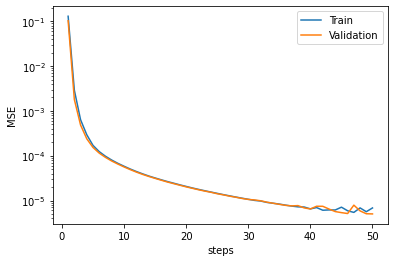

In [21]:
plot_loss(model_AE,max_epoch=50)

In [22]:
# vs. noisy case InterpFlag = False (default parameter)
class Model4DVarNet(pl.LightningModule):
    def __init__(self):
        super(Model4DVarNet, self).__init__()
        self.InterpFlag = False
              
        self.alpha           = np.array([1.,0.1])
        self.GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
        self.OptimType       = 1 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent

        self.IterUpdate     = [0,100,200,300,500,3000]#[0,2,4,6,9,15]
        self.NbProjection   = [0,0,0,0,0,0,0]#[0,0,0,0,0,0]#[5,5,5,5,5]##
        self.NbGradIter     = [10,10,10,10,20]#[0,0,1,2,3,3]#[0,2,2,4,5,5]#
        self.lrUpdate       = [1e-3,1e-3,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-7]

        self.NBGradCurrent   = NbGradIter[0]
        self.NBProjCurrent   = NbProjection[0]
        self.lrCurrent       = lrUpdate[0]
        self.model           = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,InterpFlag)        
        self.model.model_AE.load_state_dict()
        self.model.model_Grad.load_state_dict()
        self.lambda_LRAE = 0.5
        
        self.alpha_Grad = self.alpha[0]

        self.alpha_AE   = self.alpha[1]

        self.best_model_wts = copy.deepcopy(model.state_dict())
        self.best_loss = 1e10
        
        #self.train_Curr = np.copy(x_train_Init)
        self.x_test_Curr  = np.copy(x_test_Init)

        
    def configure_optimizers(self):
        self.optimizer      = optimizer   = optim.Adam([{'params': self.model.model_Grad.parameters()},
                        {'params': self.model.model_AE.parameters(), 'lr': self.lambda_LRAE * self.lrCurrent}
                        ], lr=self.lrCurrent)
        #self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.1)

        return self.optimizer
    def train_dataloader(self):
        return self.dataloaders['train']
    
    def val_dataloader(self):
        return self.dataloaders['val']
    
    def test_dataloader(self):
        return self.dataloaders['test']


    def setup(self,stage='None'):
        batch_size=128
        training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) 
        val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(x_val_Init),torch.Tensor(x_val_obs),torch.Tensor(mask_val),torch.Tensor(x_val)) 
        test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) 
        self.dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}

    def training_step(self, train_batch, batch_idx):
        running_loss = 0.0
        num_loss     = 0
        
        inputs_init,inputs_missing,masks,targets_GT  = train_batch
        outputs     = self.forward(targets_GT)
        loss    = self.loss(outputs,targets_GT)
        #retain_graph=True
        
        running_loss             += loss.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)
        epoch_loss       = running_loss / num_loss
        self.tot_loss.append(loss)
        
        self.log('train_loss',loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    

In [14]:

for epoch in range(epoch_init,num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    if ( epoch == IterUpdate[comptUpdate] ) & ( epoch > 0 ):
        # update GradFP parameters
        NBProjCurrent = NbProjection[comptUpdate]
        NBGradCurrent = NbGradIter[comptUpdate]
        lrCurrent     = lrUpdate[comptUpdate]
        
        #lrCurrent     = lrUpdate[comptUpdate]
        print("..... ")
        print("..... ")
        print("..... Update/initialize number of projections/Graditer in GradCOnvAE model # %d/%d"%(NbProjection[comptUpdate],NbGradIter[comptUpdate]))

        if( (NBProjCurrent != NbProjection[comptUpdate-1]) | (NBGradCurrent != NbGradIter[comptUpdate-1]) ):
            print("..... ")
            print("..... ")
            print("..... Update/initialize number of projections/Graditer in GradCOnvAE model # %d/%d"%(NbProjection[comptUpdate],NbGradIter[comptUpdate]))

            # update GradFP architectures
            print('..... Update model architecture')
            print("..... ")
            model = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,InterpFlag)        
            model = model.to(device)
            
            # copy model parameters from current model
            model.load_state_dict(best_model_wts)
            
            optimizer        = optim.Adam([{'params': model.model_Grad.parameters()},
                                    {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                                    ], lr=lrCurrent)

            # Suffix for file naming
            genSuffixModel = genSuffixModelBase+'_DT'+str('%02d'%(time_step))+'_'+str('%03d'%(dT))
            genSuffixModel = genSuffixModel+genSuffixObs
            if lambda_LRAE == 0. :
                  genSuffixModel = genSuffixModel+'_NoFTrAE'
            
            genSuffixModel = genSuffixModel+'_Nproj'+str('%02d'%(NBProjCurrent))
            genSuffixModel = genSuffixModel+'_Grad_'+str('%02d'%(GradType))+'_'+str('%02d'%(OptimType))+'_'+str('%02d'%(NBGradCurrent))

        else:
            # update optimizer learning rate
            print('..... Update learning rate')
            mm = 0
            lr = np.array([lrCurrent,lambda_LRAE*lrCurrent])
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr[mm]
                mm += 1

        # update counter
        if comptUpdate < len(IterUpdate)-1:
            comptUpdate += 1

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:        
        if phase == 'train':
            model.train()
        else:
            model.eval()
        running_loss         = 0.0
        running_loss_All     = 0.
        running_loss_R       = 0.
        running_loss_I       = 0.
        running_loss_AE      = 0.
        num_loss     = 0

        for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
            inputs_init    = inputs_init.to(device)
            inputs_missing = inputs_missing.to(device)
            masks          = masks.to(device)
            targets_GT     = targets_GT.to(device)
           
            optimizer.zero_grad()

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
                inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
                if model.OptimType == 1:
                    outputs,grad_new,normgrad = model(inputs_init,inputs_missing,masks,None)
                    
                elif model.OptimType == 2:
                    outputs,hidden_new,cell_new,normgrad = model(inputs_init,inputs_missing,masks,None,None)
                    
                else:                               
                    outputs,normgrad = model(inputs_init,inputs_missing,masks)
                
                loss_R      = torch.sum((outputs - targets_GT)**2 * masks )
                loss_R      = torch.mul(1.0 / torch.sum(masks),loss_R)
                loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) )
                loss_I      = torch.mul(1.0 / torch.sum(1.-masks),loss_I)
                loss_All    = torch.mean((outputs - targets_GT)**2 )
                loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )
                            
                loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )

                loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            
                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer.step()

            # statistics
            running_loss             += loss.item() * inputs_missing.size(0)
            running_loss_I           += loss_I.item() * inputs_missing.size(0)
            running_loss_R           += loss_R.item() * inputs_missing.size(0)
            running_loss_All         += loss_All.item() * inputs_missing.size(0)
            running_loss_AE          += loss_AE_GT.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)
        
        #if phase == 'train':
        #    exp_lr_scheduler.step()

        epoch_loss       = running_loss / num_loss
        epoch_loss_All   = running_loss_All / num_loss
        epoch_loss_AE    = running_loss_AE / num_loss
        epoch_loss_I     = running_loss_I / num_loss
        epoch_loss_R     = running_loss_R / num_loss            

        epoch_loss_All = epoch_loss_All * stdTr**2
        epoch_loss_I   = epoch_loss_I * stdTr**2
        epoch_loss_R   = epoch_loss_R * stdTr**2
        epoch_loss_AE  = epoch_loss_AE * stdTr**2

        #print('{} Loss: {:.4f} '.format(
          #   phase, epoch_loss))
        #print('{} Loss: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e}'.format(
        #    phase, epoch_loss,epoch_nloss_All,epoch_nloss_R,epoch_nloss_I,epoch_loss_AE))
        print('{} Loss: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e}'.format(
            phase, epoch_loss,epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss      = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/9
----------


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


KeyboardInterrupt: 

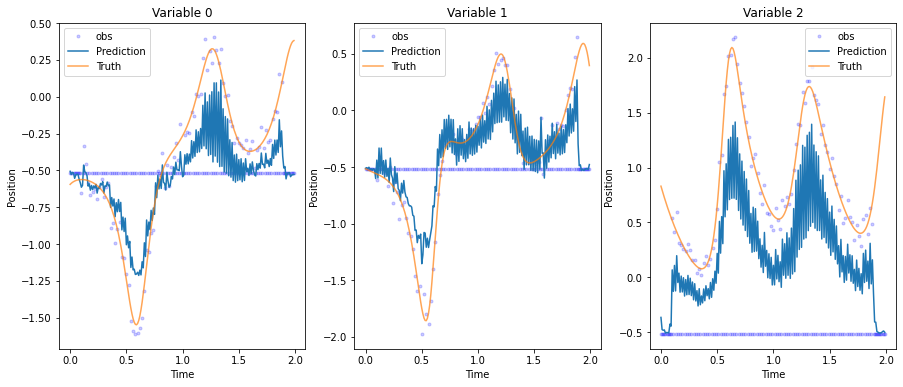

In [19]:
test= next(iter(dataloaders['test']))

x_pred=model_AE(test[1])

idx=25
x_obs=test[1][idx].detach().numpy()
x_pred=x_pred[idx].detach().numpy()
x_truth=test[3][idx].detach().numpy()


time_=np.arange(0,2,0.01)

plt.figure(figsize=(15,6))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time_,x_obs[j],'b.',alpha=0.2,label='obs')
    plt.plot(time_,x_pred[j],alpha=1,label='Prediction')
    plt.plot(time_,x_truth[j],alpha=0.7,label='Truth')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Variable {}'.format(j))
    plt.legend()
plt.savefig('Prediction.pdf')